**bold text**

In [ ]:
!pip install mido fraction music21 basic-pitch

 This post-processing step ensures that the final composition adheres to the Raga constraints, enhancing the authenticity of the generated music.

In [ ]:
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH

predict_and_save(
    ['/content/drive/MyDrive/ISMIR2024/waves/1.wav'],
    '/content/drive/MyDrive/ISMIR2024/waves/midis',
    save_midi=True,
    sonify_midi=False,
    save_model_outputs=False,
    save_notes=False,
    model_or_model_path=ICASSP_2022_MODEL_PATH
)



Predicting MIDI for /content/drive/MyDrive/ISMIR2024/waves/1.wav...


  Creating midi...
  💅 Saved to /content/drive/MyDrive/ISMIR2024/waves/midis/1_basic_pitch.mid


In [ ]:
# Mass process a folder but creates sub folder for each file
import os
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH

def process_audio_folder(source_folder, target_folder, model_path):
    # Check if the target folder exists, if not, create it
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    audio_files = [f for f in os.listdir(source_folder) if f.endswith('.wav')]
    for audio_file in audio_files:
        input_audio_path = os.path.join(source_folder, audio_file)
        output_midi_dir = os.path.join(target_folder, os.path.splitext(audio_file)[0])
        if not os.path.exists(output_midi_dir):
            os.makedirs(output_midi_dir)
        predict_and_save(
            [input_audio_path],
            output_midi_dir,
            save_midi=True,
            sonify_midi=False,
            save_model_outputs=False,
            save_notes=False,
            model_or_model_path=model_path
        )
        print(f"Processed {input_audio_path} and saved MIDI to {output_midi_dir}")

source_folder = '/content/drive/MyDrive/ISMIR2024/waves'
target_folder = '/content/drive/MyDrive/ISMIR2024/waves/midisoriginals'
process_audio_folder(source_folder, target_folder, ICASSP_2022_MODEL_PATH)



Predicting MIDI for /content/drive/MyDrive/ISMIR2024/waves/Lead7.wav...


  Creating midi...
  💅 Saved to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead7/Lead7_basic_pitch.mid
Processed /content/drive/MyDrive/ISMIR2024/waves/Lead7.wav and saved MIDI to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead7

Predicting MIDI for /content/drive/MyDrive/ISMIR2024/waves/Lead5.wav...


  Creating midi...
  💅 Saved to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead5/Lead5_basic_pitch.mid
Processed /content/drive/MyDrive/ISMIR2024/waves/Lead5.wav and saved MIDI to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead5

Predicting MIDI for /content/drive/MyDrive/ISMIR2024/waves/Lead1.wav...


  Creating midi...
  💅 Saved to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead1/Lead1_basic_pitch.mid
Processed /content/drive/MyDrive/ISMIR2024/waves/Lead1.wav and saved MIDI to /content/drive/MyDrive/ISMIR2024/waves/midisoriginals/Lead1

Predicting MIDI for /

## Single track error analysis

In [ ]:
def correct_midi_file(file_path, valid_notes):
    mid = MidiFile(file_path)
    total_erratic_notes = 0
    total_notes = 0
    erratic_notes_all_tracks = []
    replaced_notes_all_tracks = []

    new_mid = MidiFile(ticks_per_beat=mid.ticks_per_beat)

    for i, track in enumerate(mid.tracks):
        new_track = MidiTrack()
        erratic_notes = 0
        erratic_notes_list = []
        replaced_notes_list = []

        for msg in track:
            if msg.type == 'note_on' or msg.type == 'note_off':
                total_notes += 1
                if msg.note not in valid_notes:
                    erratic_notes += 1
                    total_erratic_notes += 1
                    erratic_notes_list.append(msg.note)
                    corrected_note = closest_valid(msg.note, valid_notes)
                    replaced_notes_list.append(corrected_note)
                    new_msg = Message(msg.type, note=corrected_note, velocity=msg.velocity, time=msg.time)
                    new_track.append(new_msg)
                else:
                    new_track.append(msg)
            else:
                new_track.append(msg)

        new_mid.tracks.append(new_track)
        erratic_notes_all_tracks.extend(erratic_notes_list)
        replaced_notes_all_tracks.extend(replaced_notes_list)
        print(f"Track {i+1}: {erratic_notes} erratic notes, Erratic notes: {erratic_notes_list}, Replaced notes: {replaced_notes_list}")

    new_file_path = os.path.splitext(file_path)[0] + '_corrected.mid'
    new_mid.save(new_file_path)
    return total_erratic_notes, total_notes, new_file_path, erratic_notes_all_tracks, replaced_notes_all_tracks

# Correct the MIDI file and get the number of erroneous notes
erratic_notes_count, total_notes_count, corrected_file_path, erratic_notes, replaced_notes = correct_midi_file(file_path, valid_notes)

erratic_notes_count, total_notes_count, erratic_notes, replaced_notes


Track 1: 0 erratic notes, Erratic notes: [], Replaced notes: []
Track 2: 2 erratic notes, Erratic notes: [74, 74], Replaced notes: [75, 75]


(2, 688, [74, 74], [75, 75])

## Error Analysis all songs

In [ ]:
import mido
from mido import MidiFile, MidiTrack, Message
import os

def correct_midi_file(file_path, valid_notes):
    mid = MidiFile(file_path)
    total_erratic_notes = 0
    total_notes = 0
    new_mid = MidiFile(ticks_per_beat=mid.ticks_per_beat)
    erratic_notes_list_all = []

    for i, track in enumerate(mid.tracks):
        new_track = MidiTrack()
        erratic_notes = 0
        erratic_notes_list = []
        replaced_notes_list = []

        for msg in track:
            if msg.type == 'note_on' or msg.type == 'note_off':
                total_notes += 1
                if msg.note not in valid_notes:
                    erratic_notes += 1
                    total_erratic_notes += 1
                    erratic_notes_list.append(msg.note)
                    erratic_notes_list_all.append(msg.note)
                    corrected_note = closest_valid(msg.note, valid_notes)
                    replaced_notes_list.append(corrected_note)
                    new_msg = Message(msg.type, note=corrected_note, velocity=msg.velocity, time=msg.time)
                    new_track.append(new_msg)
                else:
                    new_track.append(msg)
            else:
                new_track.append(msg)

        new_mid.tracks.append(new_track)
        print(f"Track {i+1}: {erratic_notes} erratic notes, Erratic notes: {erratic_notes_list}, Replaced notes: {replaced_notes_list}")

    new_file_path = os.path.splitext(file_path)[0] + '_corrected.mid'
    new_mid.save(new_file_path)
    return total_erratic_notes, total_notes, new_file_path, erratic_notes_list_all

def closest_valid(note, valid_notes):
    return min(valid_notes, key=lambda x: abs(x-note))

def process_folder(source_folder, target_folder, valid_notes):
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    total_files_processed = 0
    total_erratic_notes_all = 0
    total_notes_all = 0
    erratic_notes_all_files = []

    for file in os.listdir(source_folder):
        if file.endswith(".mid") and '_corrected' not in file:
            print(f"Processing: {file}")  # Print the name of the file being processed
            source_file_path = os.path.join(source_folder, file)
            total_erratic_notes, total_notes, corrected_file_path, erratic_notes_list = correct_midi_file(source_file_path, valid_notes)
            total_files_processed += 1
            total_erratic_notes_all += total_erratic_notes
            total_notes_all += total_notes
            erratic_notes_all_files.extend(erratic_notes_list)

            target_file_path = os.path.join(target_folder, os.path.basename(corrected_file_path))
            # Move the corrected file to the target folder
            os.rename(corrected_file_path, target_file_path)
            print(f"Processed and moved to {target_file_path}")

    if total_files_processed > 0:
        average_error_percentage = (total_erratic_notes_all / total_notes_all) * 100 if total_notes_all > 0 else 0
        print(f"\nTotal files processed: {total_files_processed}")
        print(f"Total erratic notes: {total_erratic_notes_all}")
        print(f"Total notes: {total_notes_all}")
        print(f"Average error percentage: {average_error_percentage:.2f}%")
        print(f"List of all erratic notes: {erratic_notes_all_files}")
    else:
        print("No files processed.")

valid_notes = {
    24, 27, 28, 29, 31, 34, 35, 36, 39, 40, 41, 43, 46, 47,
    48, 51, 52, 53, 55, 58, 59, 60, 63, 64, 65, 67, 70, 71, 72,
    75, 76, 77, 79, 82, 83, 84, 87, 88, 89, 91, 94, 95, 96
}
source_folder = '/content/drive/MyDrive/ISMIR2024/waves/midisoriginals'
target_folder = '/content/drive/MyDrive/ISMIR2024/waves/correctedMidis'
process_folder(source_folder, target_folder, valid_notes)


Processing: Lead3_basic_pitch.mid
Track 1: 0 erratic notes, Erratic notes: [], Replaced notes: []
Track 2: 12 erratic notes, Erratic notes: [69, 69, 69, 69, 62, 62, 74, 74, 74, 74, 78, 78], Replaced notes: [70, 70, 70, 70, 63, 63, 75, 75, 75, 75, 77, 77]
Processed and moved to /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/Lead3_basic_pitch_corrected.mid
Processing: 1_basic_pitch (1).mid
Track 1: 0 erratic notes, Erratic notes: [], Replaced notes: []
Track 2: 18 erratic notes, Erratic notes: [78, 78, 74, 62, 38, 62, 50, 62, 74, 38, 38, 50, 62, 38, 45, 45, 62, 62], Replaced notes: [77, 77, 75, 63, 39, 63, 51, 63, 75, 39, 39, 51, 63, 39, 46, 46, 63, 63]
Processed and moved to /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/1_basic_pitch (1)_corrected.mid
Processing: Lead2_basic_pitch.mid
Track 1: 0 erratic notes, Erratic notes: [], Replaced notes: []
Track 2: 2 erratic notes, Erratic notes: [56, 56], Replaced notes: [55, 55]
Processed and moved to /content/drive/MyDrive/ISMI

Mido to analyze and correct the notes as per the Raga constraints.

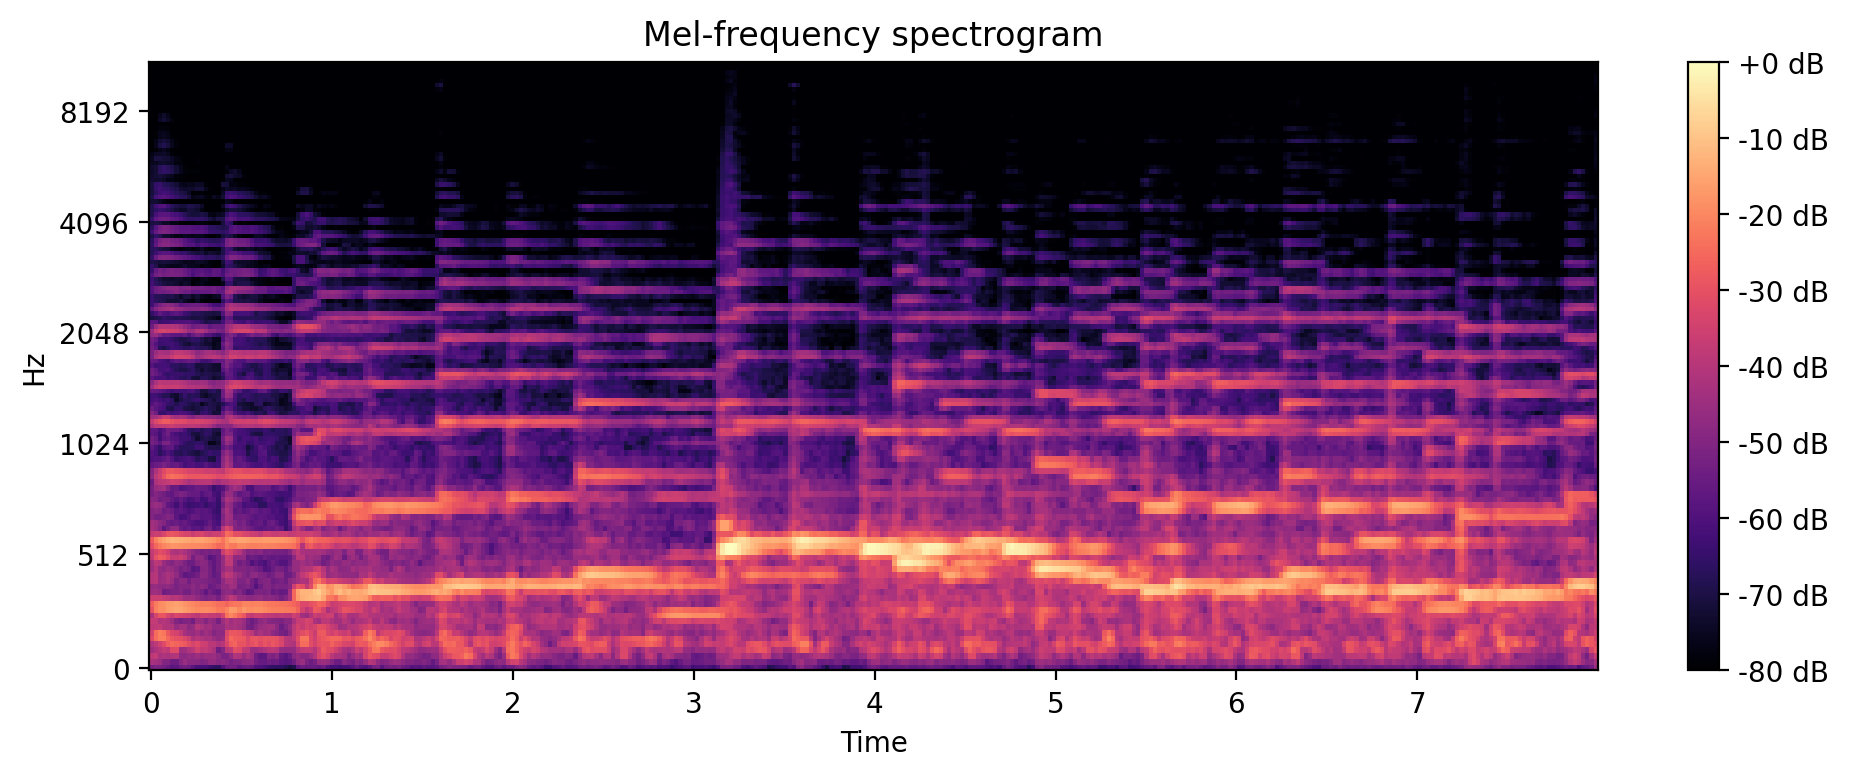

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
y, sr = librosa.load('/content/drive/MyDrive/ISMIR2024/waves/Lead1.wav')

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert the power spectrogram to decibels
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


The waveform plot shows the amplitude of the audio signal over time. It provides a visual representation of the loudness and dynamics of the sound.



In [ ]:
def plot_waveform(y, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()


The Mel Spectrogram is a spectrogram where the frequencies are converted to the Mel scale. It is commonly used in speech and music processing as it is more perceptually relevant than the linear frequency scale.



In [ ]:
def plot_mel_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()


A chromagram is a representation of the energy content of each pitch class (e.g., C, C#, D, etc.) over time. It is useful for analyzing the harmonic content of music.



In [ ]:
def plot_chromagram(y, sr):
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chromagram, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()


Interpretation and Melodic Range
Waveform Plot: Look for variations in amplitude over time, which indicate changes in loudness. Sudden spikes represent transient sounds or beats.
Mel Spectrogram: Brighter areas indicate higher energy at specific frequencies and times. You can observe the texture, timbre, and overall frequency content of the music.
Chromagram: Brighter columns indicate the presence of specific pitch classes at given times. You can use this to analyze the harmonic progression and key changes in the music.
To visually check the adherence to the melodic range of Jog Raga, you can use the chromagram. The pitches in the melodic range [58, 59, 60, 63, 64, 65, 67, 70, 71, 72, 75, 76, 77, 79] correspond to specific pitch classes. By examining the chromagram, you can see if the energy is concentrated around these pitch classes and if the melody predominantly uses notes within this range.

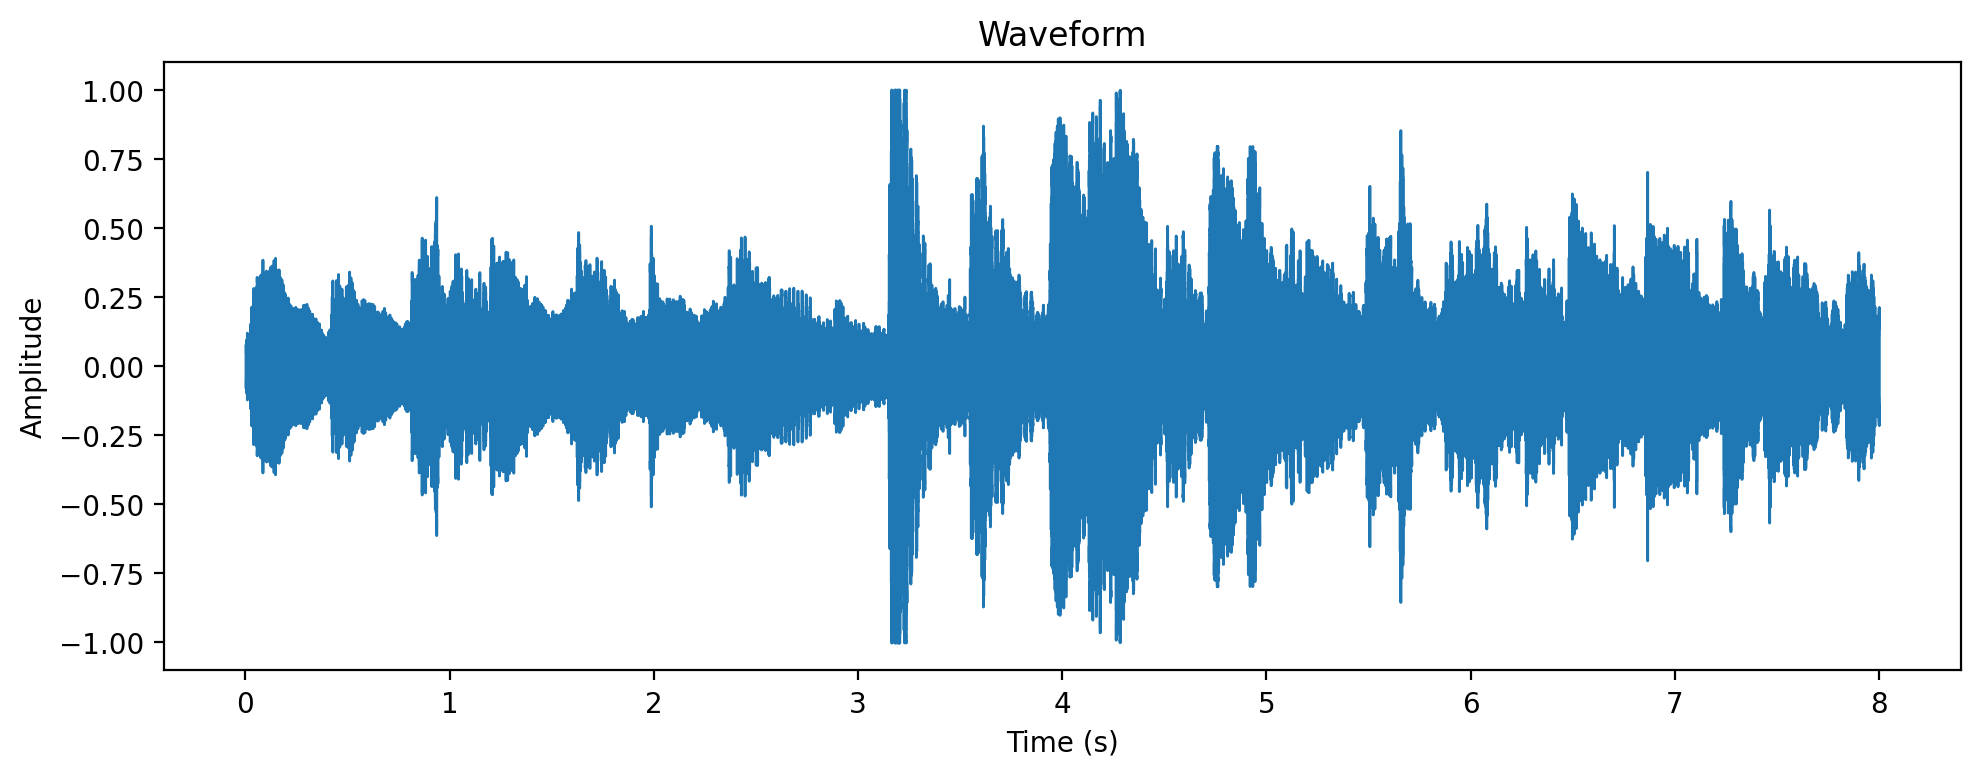

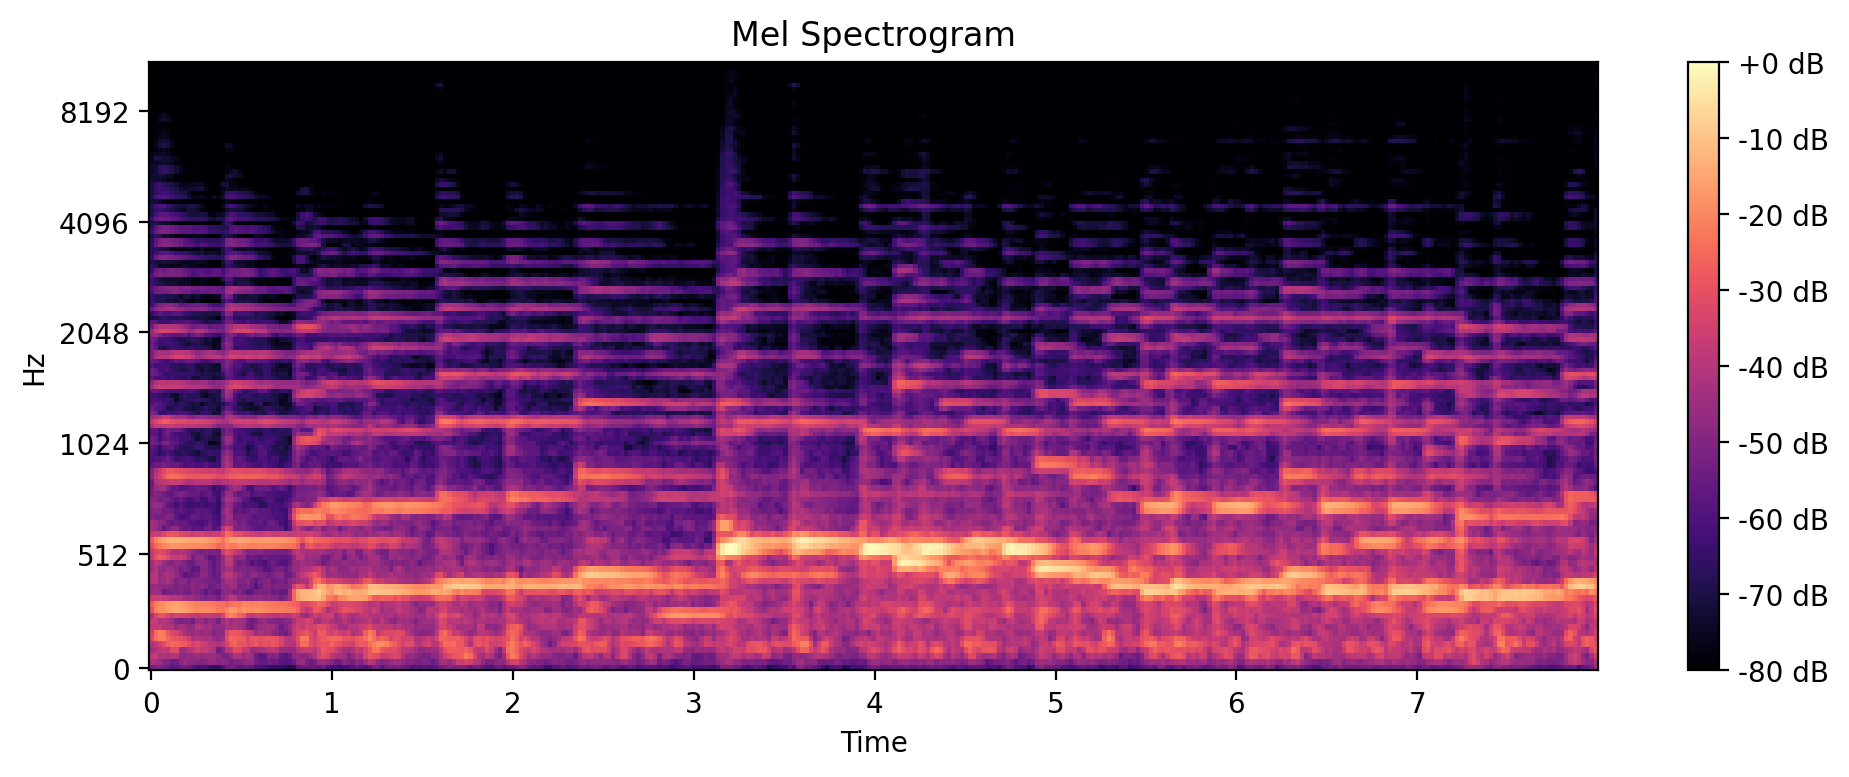

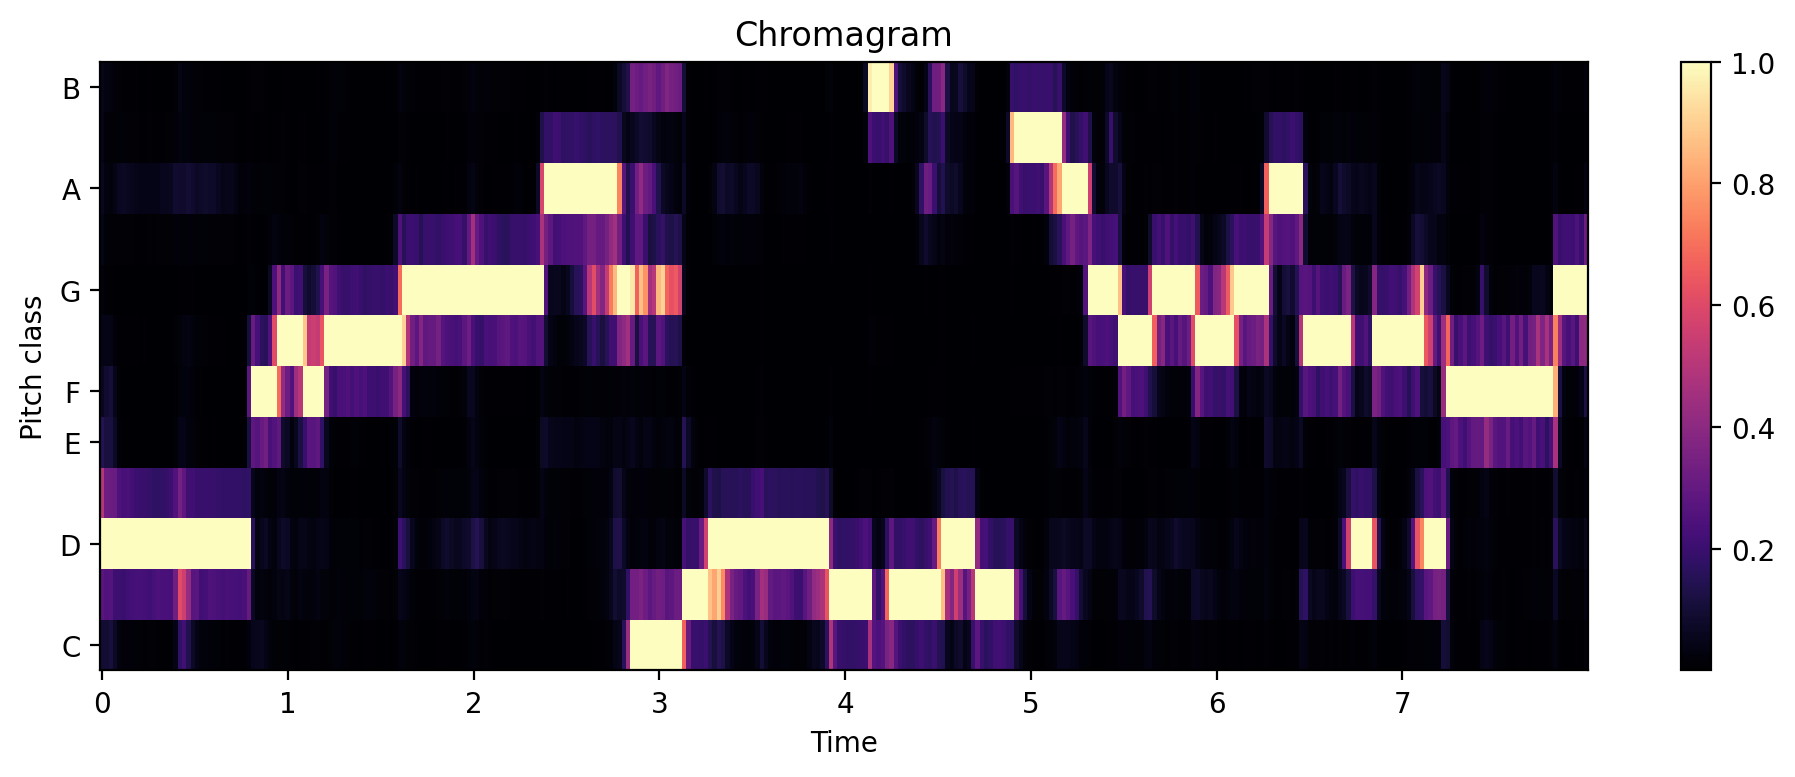

In [ ]:
# plotting
y, sr = librosa.load('/content/drive/MyDrive/ISMIR2024/waves/Lead1.wav')
plot_waveform(y, sr)
plot_mel_spectrogram(y, sr)
plot_chromagram(y, sr)

# Corrected file plotting

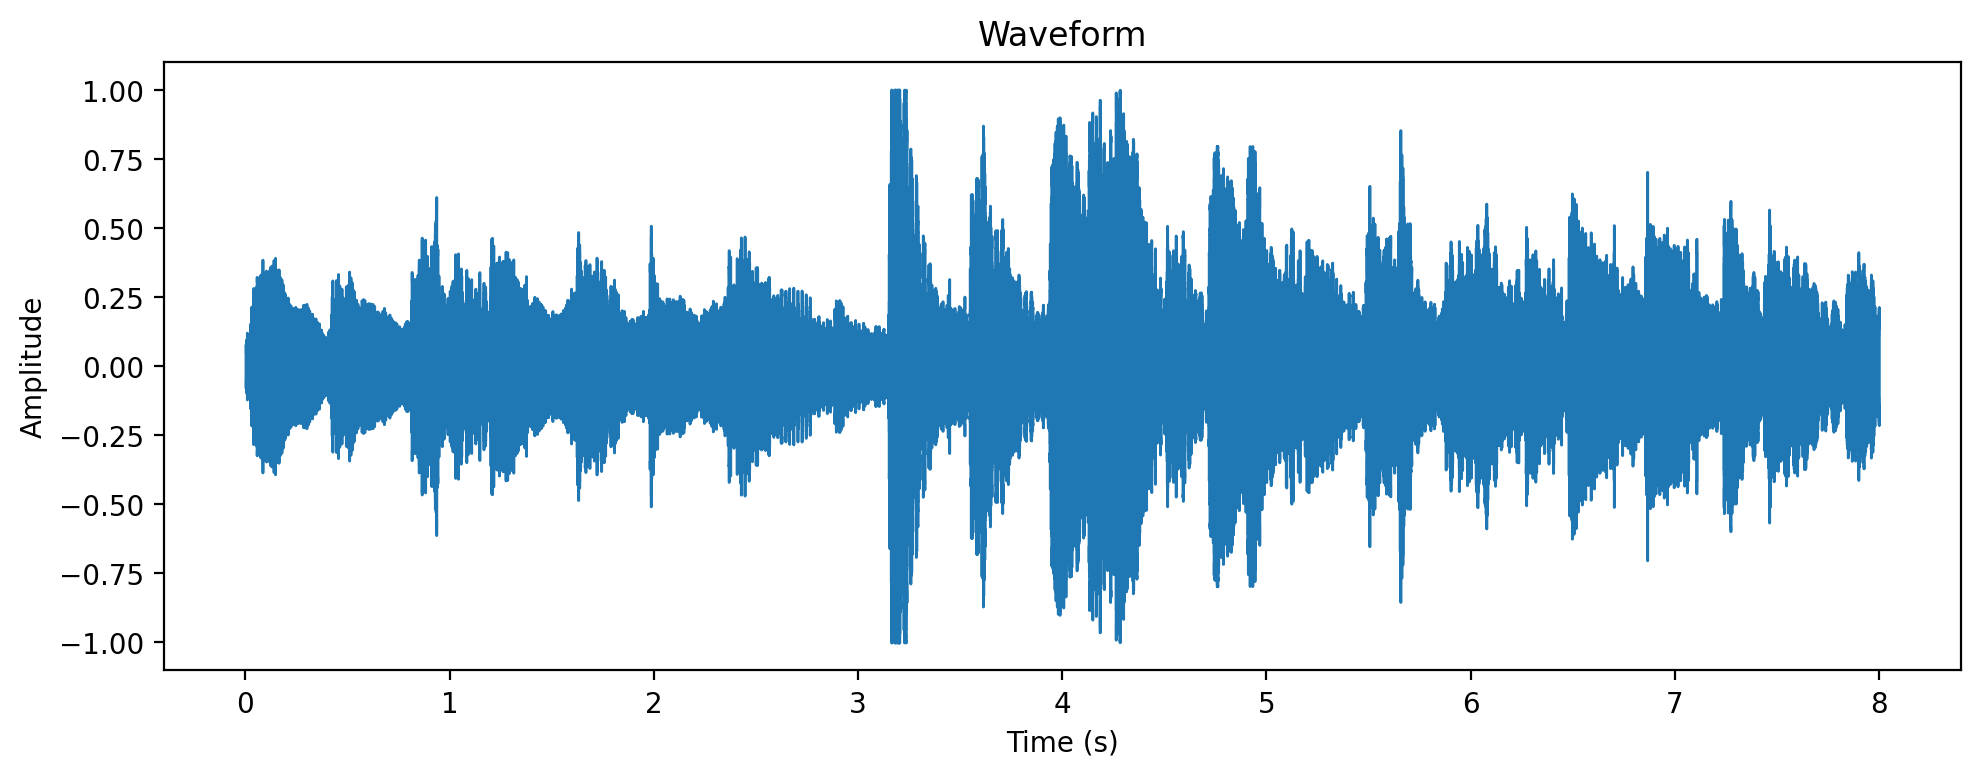

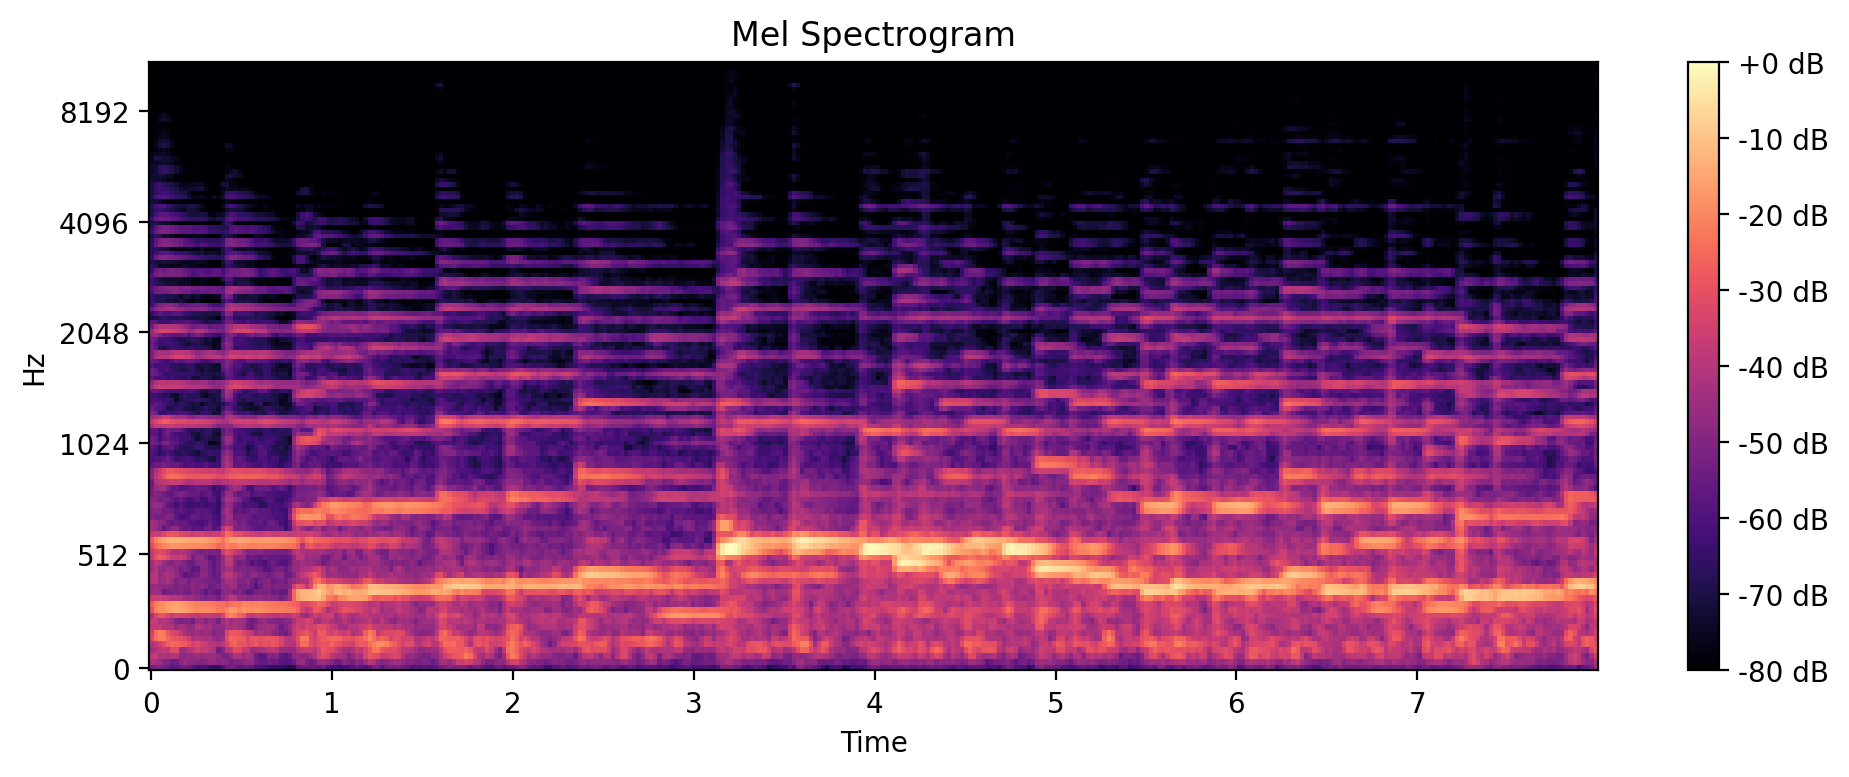

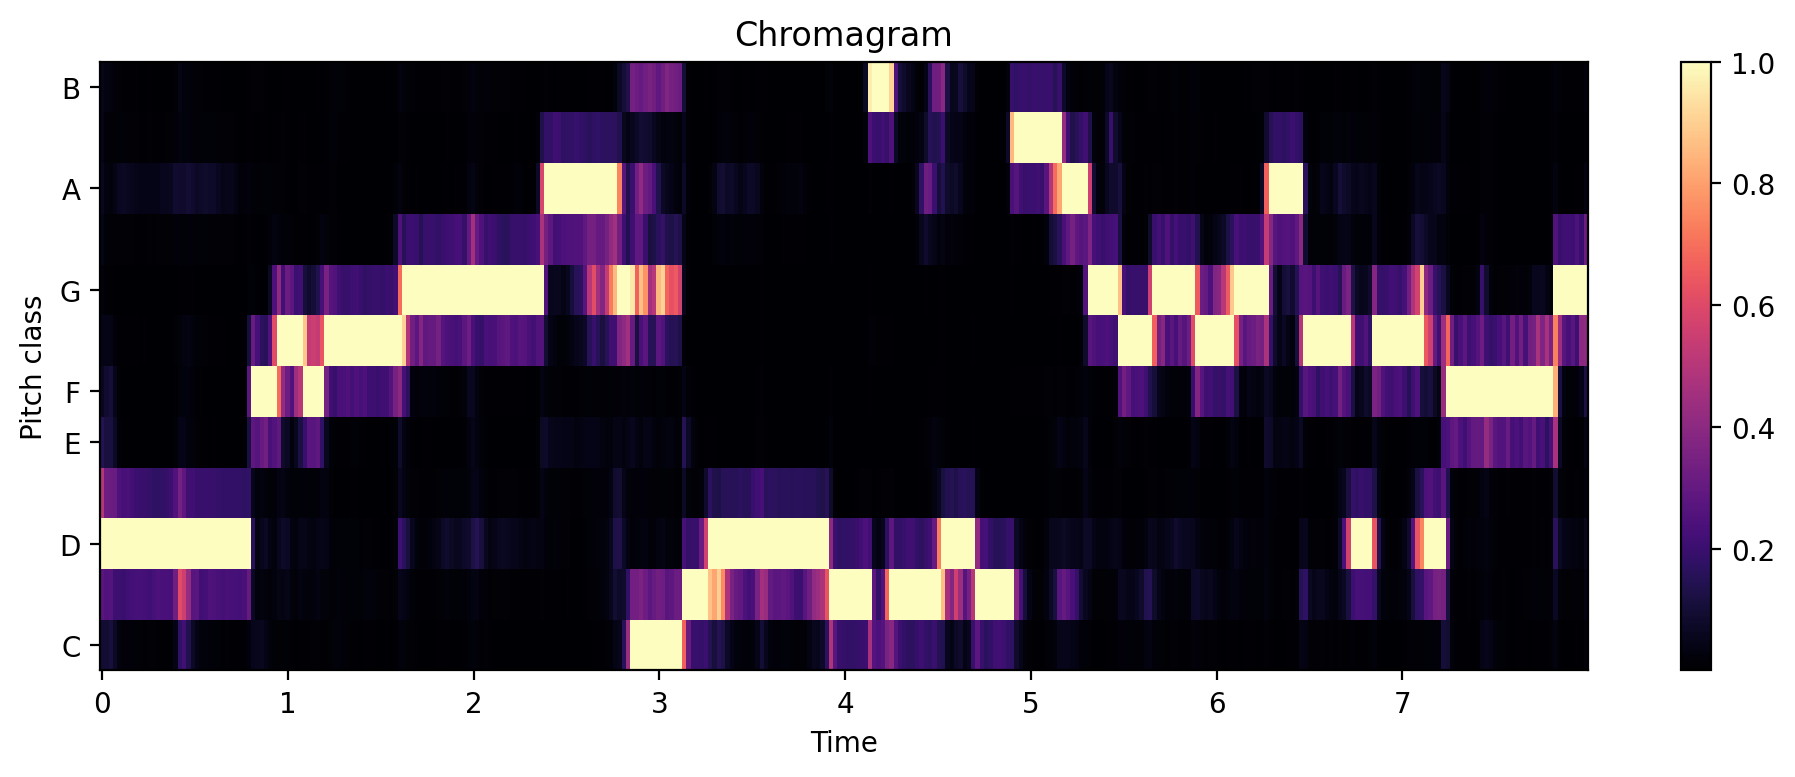

In [ ]:
# Load the audio file
from music21 import converter
import os

# Load the MIDI file
midi_file_path = '/content/drive/MyDrive/ISMIR2024/waves/midis_corrected/Lead1_basic_pitch_corrected.mid'
midi_stream = converter.parse(midi_file_path)
# Load the audio file
y, sr = librosa.load(wav_file_path)

# Call the plotting functions
plot_waveform(y, sr)
plot_mel_spectrogram(y, sr)
plot_chromagram(y, sr)

# Analyze tonal purity and emphasizing notes

In [ ]:
from collections import Counter
def analyze_tonal_purity(midi_file_path, vadi_note, samvadi_note):
    mid = MidiFile(midi_file_path)
    note_counts = Counter()

    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on':
                note_counts[msg.note] += 1

    total_notes = sum(note_counts.values())
    vadi_percentage = (note_counts[vadi_note] / total_notes) * 100
    samvadi_percentage = (note_counts[samvadi_note] / total_notes) * 100
    return vadi_percentage, samvadi_percentage

In [ ]:
# Check start and end on tonic
def check_start_end_tonic(midi_file_path, tonic_note):
    mid = MidiFile(midi_file_path)
    first_note = None
    last_note = None

    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on':
                if first_note is None:
                    first_note = msg.note
                last_note = msg.note

    return first_note == tonic_note and last_note == tonic_note


In [ ]:
# Check singing voice range
def check_voice_range(midi_file_path, min_note, max_note):
    mid = MidiFile(midi_file_path)
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on':
                if msg.note < min_note or msg.note > max_note:
                    return False
    return True


# Analyze all MIDI files in the folder

In [ ]:
from mido import MidiFile
import os

def analyze_midi_files(folder_path):
    total_vadi_percentage = 0
    total_samvadi_percentage = 0
    total_files = 0

    for file in os.listdir(folder_path):
        if file.endswith(".mid"):
            file_path = os.path.join(folder_path, file)
            print(f"Analyzing {file_path}")
            vadi_percentage, samvadi_percentage = analyze_tonal_purity(file_path, vadi_note=55, samvadi_note=70)
            total_vadi_percentage += vadi_percentage
            total_samvadi_percentage += samvadi_percentage
            total_files += 1
            print(f"Vadi (G3) note prominence: {vadi_percentage:.2f}%")
            print(f"Samvadi (N3) note prominence: {samvadi_percentage:.2f}%")
            tonic_start_end = check_start_end_tonic(file_path, tonic_note=60)
            print(f"Start and end on tonic (Sa): {tonic_start_end}")
            voice_range = check_voice_range(file_path, min_note=58, max_note=84)
            print(f"Singing voice range within B♭2 to C6: {voice_range}")
            # Add more analysis functions as needed

    if total_files > 0:
        average_vadi_percentage = total_vadi_percentage / total_files
        average_samvadi_percentage = total_samvadi_percentage / total_files
        print(f"\nAverage Vadi (G3) note prominence across all files: {average_vadi_percentage:.2f}%")
        print(f"Average Samvadi (N3) note prominence across all files: {average_samvadi_percentage:.2f}%")
    else:
        print("No MIDI files found.")

target_folder = '/content/drive/MyDrive/ISMIR2024/waves/correctedMidis'
analyze_midi_files(target_folder)


Analyzing /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/Lead3_basic_pitch_corrected.mid
Vadi (G3) note prominence: 10.85%
Samvadi (N3) note prominence: 8.47%
Start and end on tonic (Sa): False
Singing voice range within B♭2 to C6: False
Analyzing /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/1_basic_pitch (1)_corrected.mid
Vadi (G3) note prominence: 0.89%
Samvadi (N3) note prominence: 5.36%
Start and end on tonic (Sa): False
Singing voice range within B♭2 to C6: False
Analyzing /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/Lead2_basic_pitch_corrected.mid
Vadi (G3) note prominence: 10.08%
Samvadi (N3) note prominence: 8.40%
Start and end on tonic (Sa): False
Singing voice range within B♭2 to C6: False
Analyzing /content/drive/MyDrive/ISMIR2024/waves/correctedMidis/Lead instrument_basic_pitch_corrected.mid
Vadi (G3) note prominence: 12.78%
Samvadi (N3) note prominence: 4.47%
Start and end on tonic (Sa): False
Singing voice range within B♭2 to C6: False
Analyzing /